# Plant-pollinator project
Plant-pollinator networks describe the interaction between different types of pollinators and plants of a certain territory. It is possible to represent it as a bipartite network with two node types: plant nodes (green), pollinator nodes (red).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import utils
import motifs

%matplotlib inline

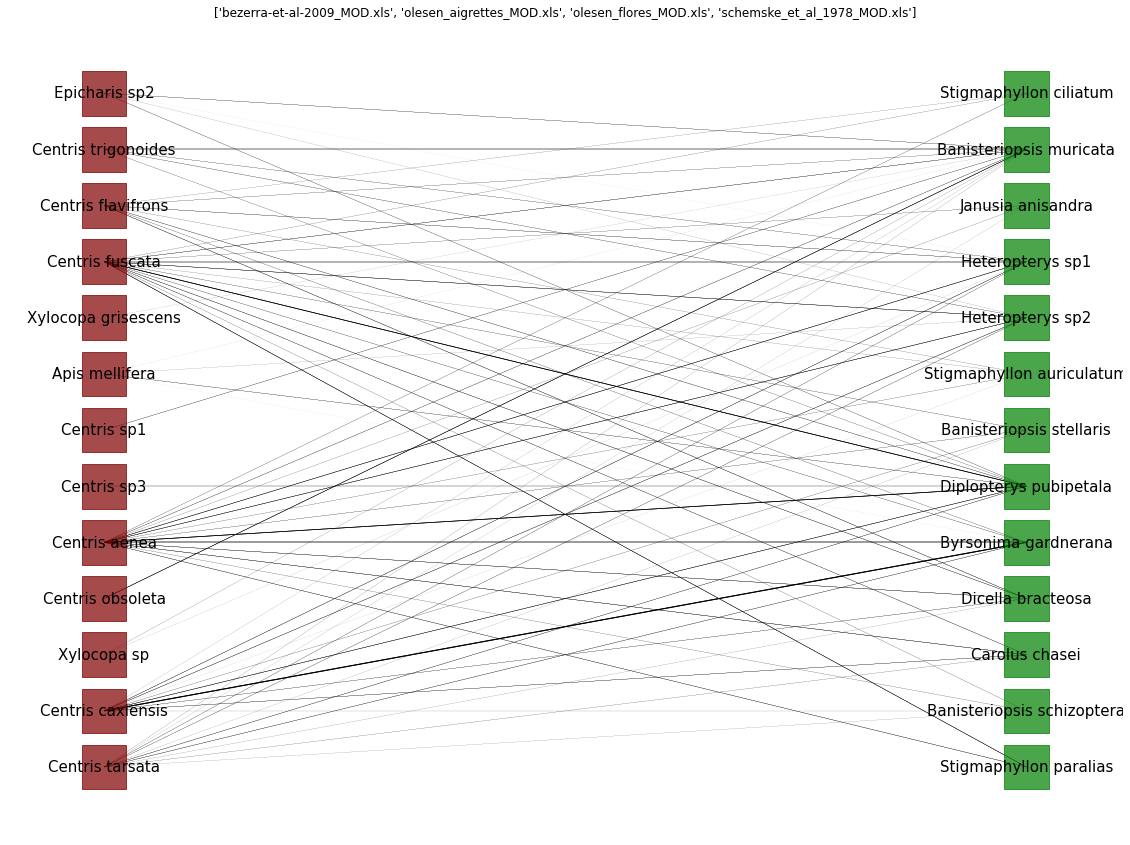

In [2]:
DATA_FOLDER = '../dataset/'
DATASET = [	'bezerra-et-al-2009_MOD.xls', 
			'olesen_aigrettes_MOD.xls',
			'olesen_flores_MOD.xls',
			'schemske_et_al_1978_MOD.xls']
data_index = 0
path = DATA_FOLDER + DATASET[data_index]

# plot a bipartite graph
G, pol, pla = utils.build_graph_from_xls(path, verbose=False)
utils.plot_bipartite_graph(G, pol, title=DATASET)
plt.show()

## Centralities
The first thing we tried to understand is which are the most important plants and pollinators of the network. The "importance" of a node can be measured by different types of centralities. For example we can consider nodes with the highest degree as the most important since they have the most number of connections in the network...

In [5]:
dc = utils.degree_centrality(G)
cc, bc = utils.compute_centralities(G)
Bc = utils.compute_birank_centrality(G)
centralities = [dc, cc, bc]
centralities_names = ['dc', 'cc', 'bc']

K = 5

In [6]:
# Top K pollinators in the network according to different centralities
df_pol = utils.top_K_nodes_df(G, centralities, centralities_names, K=K, all_nodes=False, show_value=False, only_pollinators=True)
df_pol.join(Bc[0]['pollinators']).rename(
    columns={'dc' : 'degree centrality',
             'cc' : 'closeness centrality',
             'bc' : 'betweenness centrality',
             'pollinators': 'BiRank centrality'
             })

,degree centrality,closeness centrality,betweenness centrality,BiRank centrality
1,Centris aenea,Centris aenea,Centris aenea,Centris fuscata
2,Centris fuscata,Centris fuscata,Centris fuscata,Centris caxiensis
3,Centris caxiensis,Centris caxiensis,Centris tarsata,Centris tarsata
4,Centris tarsata,Centris tarsata,Centris caxiensis,Centris flavifrons
5,Centris flavifrons,Centris flavifrons,Centris flavifrons,Centris trigonoides


In [7]:
# Top K plants in the network according to different centralities
df_pla = utils.top_K_nodes_df(G, centralities, centralities_names, K=K, all_nodes=False, show_value=False, only_plants=True)
df_pla.join(Bc[1]['plants']).rename(
    columns={'dc' : 'degree centrality',
             'cc' : 'closeness centrality',
             'bc' : 'betweenness centrality',
             'plants': 'BiRank centrality'
             })

,degree centrality,closeness centrality,betweenness centrality,BiRank centrality
1,Banisteriopsis muricata,Banisteriopsis muricata,Banisteriopsis muricata,Byrsonima gardnerana
2,Diplopterys pubipetala,Diplopterys pubipetala,Diplopterys pubipetala,Banisteriopsis muricata
3,Heteropterys sp1,Heteropterys sp1,Heteropterys sp1,Heteropterys sp1
4,Heteropterys sp2,Heteropterys sp2,Heteropterys sp2,Heteropterys sp2
5,Byrsonima gardnerana,Byrsonima gardnerana,Byrsonima gardnerana,Dicella bracteosa


In [8]:
MAX_NODE_SIZE = 2500

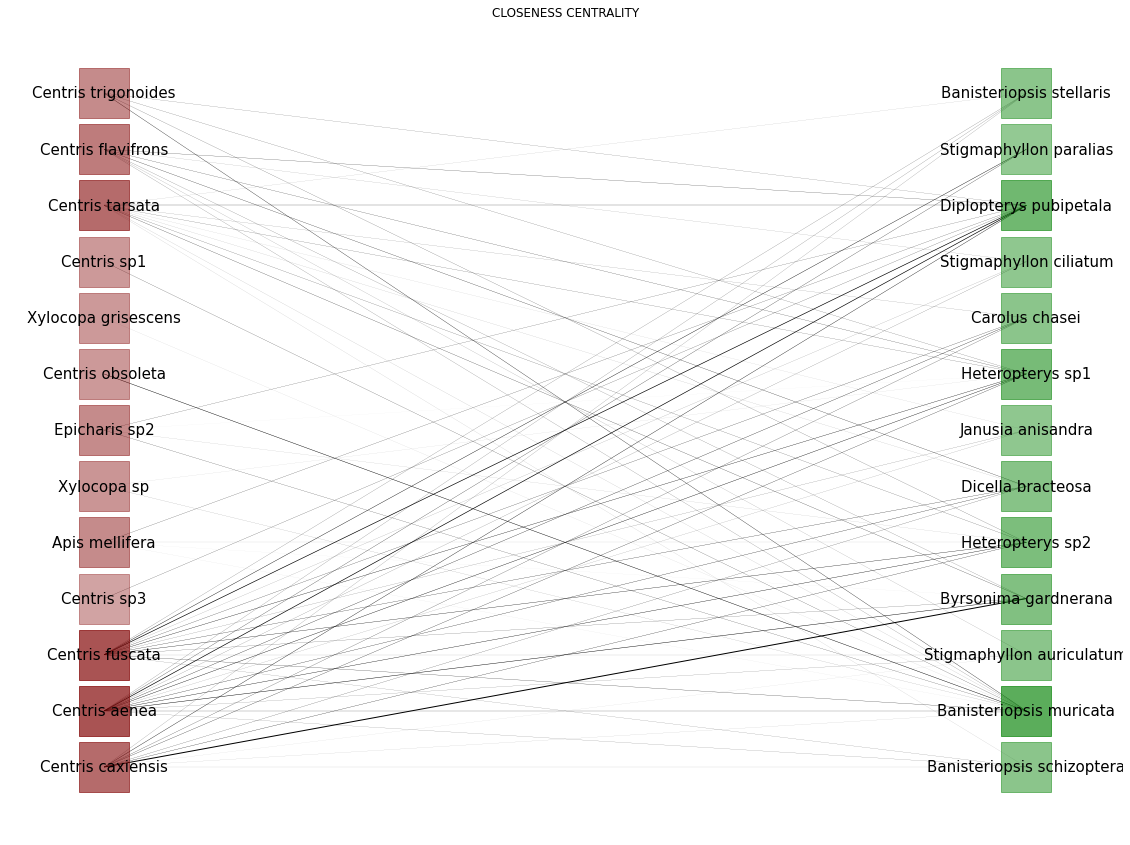

In [9]:
utils.plot_centrality_graph(G, pol, cc, size=False, max_node_size=MAX_NODE_SIZE, title='CLOSENESS CENTRALITY')

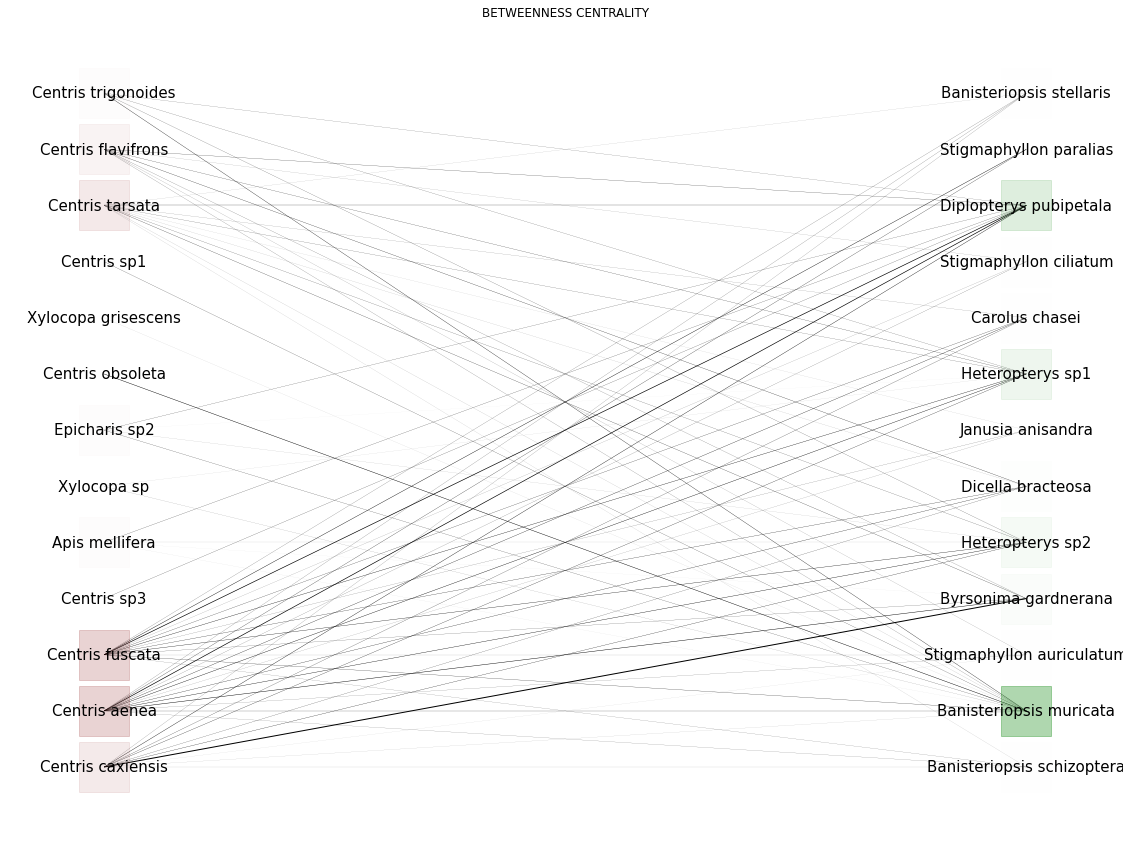

In [10]:
utils.plot_centrality_graph(G, pol, bc, size=False, max_node_size=MAX_NODE_SIZE,title='BETWEENNESS CENTRALITY')

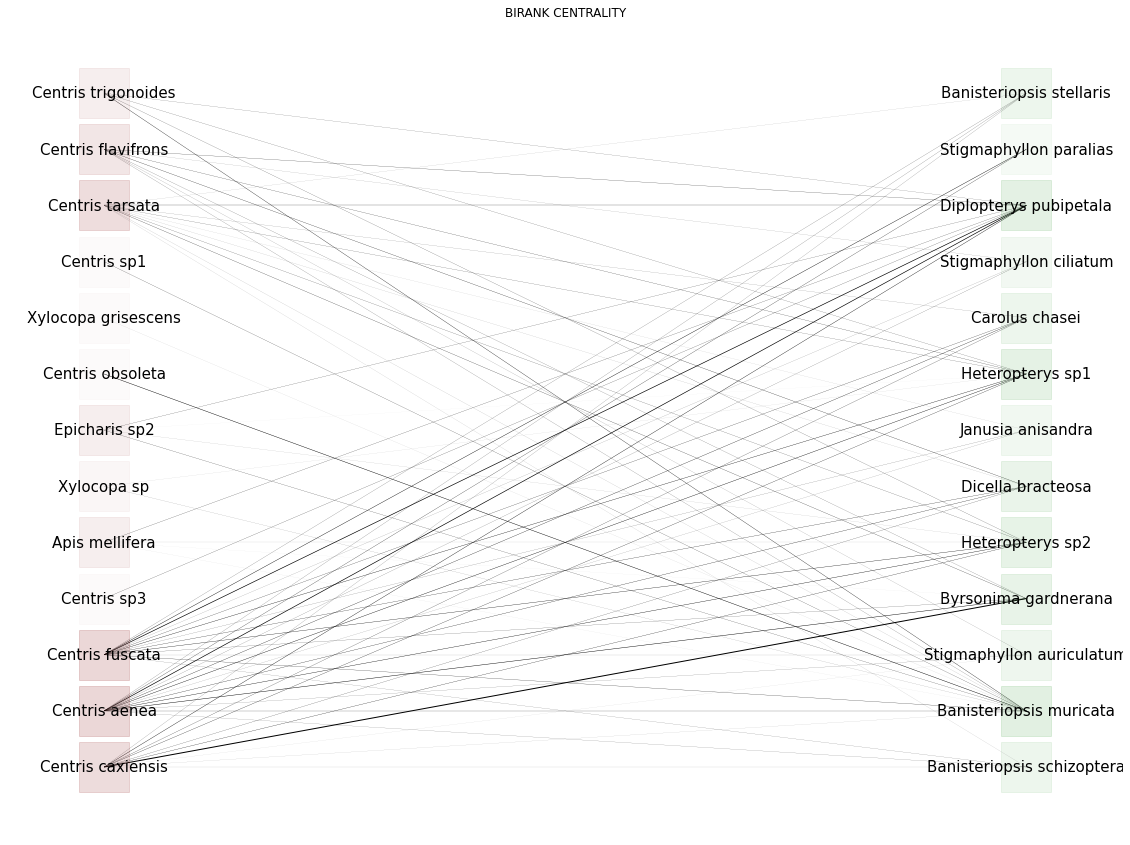

In [11]:
Bc[0]
bi_pol = {node: rank for node, rank in zip(Bc[0]['pollinators'], Bc[0]['pollinators_birank'])}
bi_pla = {node: rank for node, rank in zip(Bc[1]['plants'], Bc[1]['plants_birank'])}
BI = dict(list(bi_pol.items()) + list(bi_pla.items()))
utils.plot_centrality_graph(G, pol, BI, size=False, max_node_size=MAX_NODE_SIZE, title='BIRANK CENTRALITY')

In [3]:
# Load all the datasets
PATHS, FILE_NAMES = utils.load_paths(DATA_FOLDER)
Graphs, pollinators, plants = utils.build_all_graphs(PATHS)

In [13]:
# Computes the top K pollinators and plants among all the datasets
top_K_pol = []
top_K_pla = []
for i in range(len(Graphs)):
    _, c = utils.compute_centralities(Graphs[i])

    c_pol = {node : c[node] for node in nx.bipartite.sets(Graphs[i])[0]} # get the centrality value  for pollinators
    c_pla = {node : c[node] for node in nx.bipartite.sets(Graphs[i])[1]} # get the centrality value  for plants
    
    c_pol = sorted(c_pol.items(), key=lambda x: x[1], reverse=True )     # sort nodes according to their centrality value
    c_pla = sorted(c_pla.items(), key=lambda x: x[1], reverse=True )     # from the highest to the lowest
    
    # Consider just the node's name
    c_pol = [element[0] for element in c_pol]
    c_pla = [element[0] for element in c_pla]
    
    top_K_pol.append(c_pol[0:K])
    top_K_pla.append(c_pla[0:K])

In [14]:
# Top K pollinators among all the datasets
d = {name : col for name, col in zip(FILE_NAMES, top_K_pol)}
pd.DataFrame(data=d, index=range(1, K+1))

,olesen_aigrettes_MOD.xls,bezerra-et-al-2009_MOD.xls,schemske_et_al_1978_MOD.xls,olesen_flores_MOD.xls
1,Apis mellifera,Centris aenea,Bombus greseocollis,Halictus sp.
2,Phelsuma ornata,Centris fuscata,Metasyrphus americanus,Sepsis thoracica
3,Stratiomydae sp.,Centris tarsata,Andrena irgeniae,Musca domestica
4,Leptotes pirithous,Centris caxiensis,Andrena carlini,Bombus ruderatus
5,Syrphid sp.,Centris flavifrons,Andrena forbesii,Colias crocea


In [15]:
# Top K plants among all the datasets
d = {name : col for name, col in zip(FILE_NAMES, top_K_pla)}
pd.DataFrame(data=d, index=range(1, K+1))

,olesen_aigrettes_MOD.xls,bezerra-et-al-2009_MOD.xls,schemske_et_al_1978_MOD.xls,olesen_flores_MOD.xls
1,Gastonia mauritiana,Banisteriopsis muricata,Claytonia virginica,Azorina vidalii
2,Pemphis acidula,Diplopterys pubipetala,Isopyrum biternatum,Crithmum maritimum
3,Stachytapheta jamaicencis,Heteropterys sp1,Dentaria laciniata,Chamomilla suaveolens
4,Scaevola sericea,Heteropterys sp2,Erythronium albidum,Solidago sempervivens
5,Thespesia populnea,Byrsonima gardnerana,Sanguinaria canadensis,Daucus carota


## Clustering Coefficients

We try to compute the clustering coefficient via robins alexander algorithm. To check if they are significant in a statistical view, we compute also the z scores and the p values.

In [26]:
cc_graphs = []
z_scores = []
p_values = []

for g in Graphs:
  cc_graphs.append(utils.compute_cc(g))
  z_scores.append(utils.compute_z_score_for_cc(g, 1000))
  p_values.append(utils.compute_p_value_for_cc(g, 1000))



In [27]:
cc_graphs = {"Dataset": FILE_NAMES, "cc(G)": cc_graphs, "z score" : z_scores, "P[cc(G') < cc(G)]":p_values}
pd.DataFrame(data=cc_graphs)

,Dataset,cc(G),z score,P[cc(G') < cc(G)]
0,olesen_aigrettes_MOD.xls,0.370123,2.971547,0.994
1,bezerra-et-al-2009_MOD.xls,0.640945,8.418869,1.000
2,schemske_et_al_1978_MOD.xls,0.405451,6.683507,1.000
3,olesen_flores_MOD.xls,0.228571,0.639352,0.717


## Motifs

For each graph, compute the ESU algorithm for bipartite graphs (motifs.py) with k = 6. Then find z-scores and p-value using Monte-Carlo approach.

bezerra-et-al-2009_MOD.xls : Top 10 motifs
Graphlet 0: z-score: 68.85678163039269          p-value: 0.0


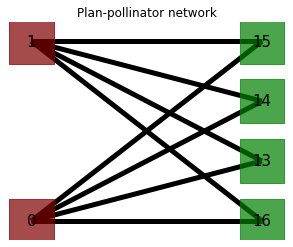

Graphlet 1: z-score: 34.39696685069613          p-value: 0.0


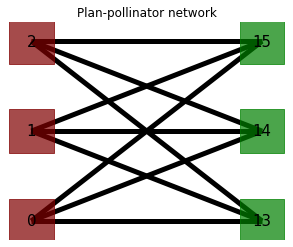

Graphlet 2: z-score: 32.11649685965139          p-value: 0.0


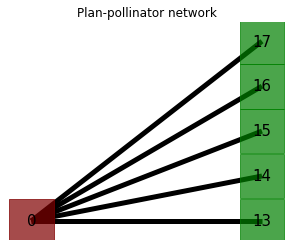

Graphlet 3: z-score: 26.76197535836279          p-value: 0.0


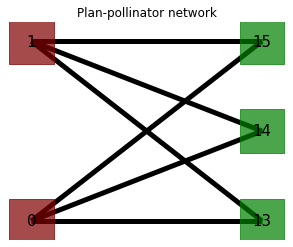

Graphlet 4: z-score: 24.42834864407495          p-value: 0.0


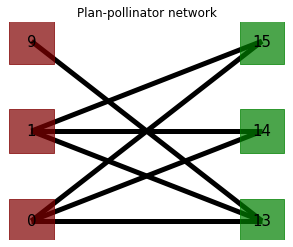

Graphlet 5: z-score: 23.284232202144317          p-value: 0.0


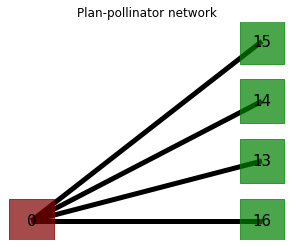

Graphlet 6: z-score: 21.445525847089346          p-value: 0.0


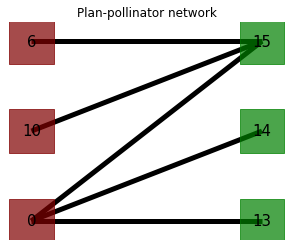

Graphlet 7: z-score: 18.51164866027869          p-value: 0.0


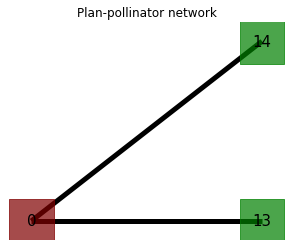

Graphlet 8: z-score: 18.250003116962144          p-value: 0.0


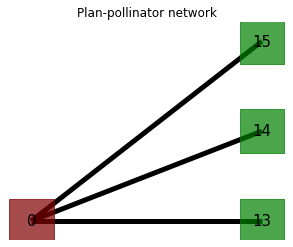

Graphlet 9: z-score: 17.414449147768426          p-value: 0.0


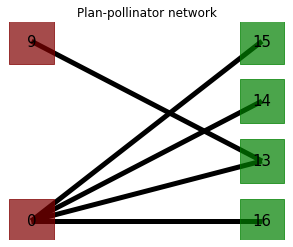

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
olesen_aigrettes_MOD.xls : Top 10 motifs
Graphlet 0: z-score: 71.53146319631112          p-value: 0.0


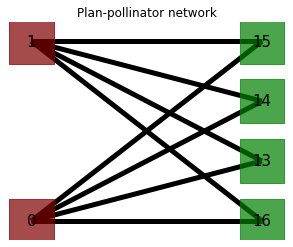

Graphlet 1: z-score: 41.38635463762894          p-value: 0.0


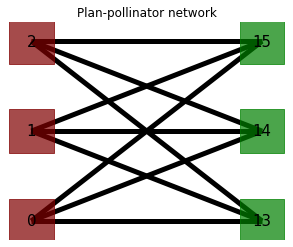

Graphlet 2: z-score: 30.862860442814856          p-value: 0.0


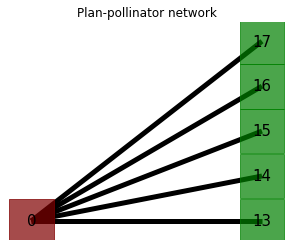

Graphlet 3: z-score: 28.523472816594353          p-value: 0.0


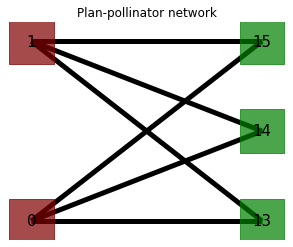

Graphlet 4: z-score: 24.887104417881858          p-value: 0.0


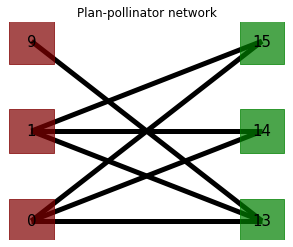

Graphlet 5: z-score: 23.98835722489409          p-value: 0.0


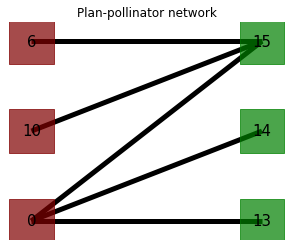

Graphlet 6: z-score: 20.030670503899156          p-value: 0.0


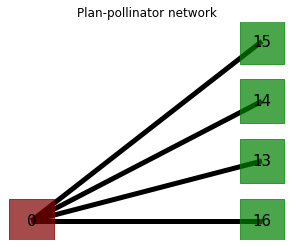

Graphlet 7: z-score: 17.843924857981616          p-value: 0.0


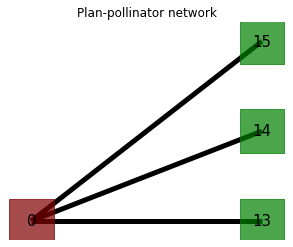

Graphlet 8: z-score: 16.802828575051556          p-value: 0.0


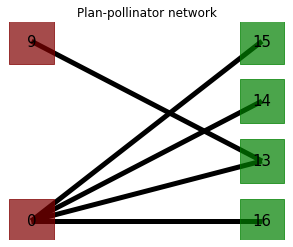

Graphlet 9: z-score: 14.916015014929698          p-value: 0.0


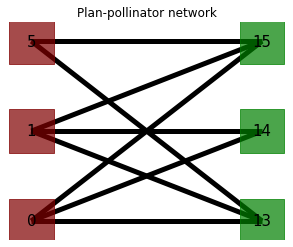

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


KeyboardInterrupt: 

In [5]:
for i in range(len(Graphs)):
    # define the maximum size of the a possible graphlet. The minimum size of the graphlet is setted to 3 by default
    max_k = 6

    total_graphlets = []
    total_z_score = []
    total_p_value = []

    for k in range(3, max_k+1):
        # compute the counting of all subgraphs (#nodes = k) of graph G 
        graphlets, counts = motifs.ESU_bipartite_version(G, k)

        z_score, p_value = motifs.compute_graphlets_scores(G, k, graphlets, counts, num_random_graphs=100)

        # compute the motifs
        top_graphlets, top_z_score, top_p_value = motifs.find_top_graphlets(graphlets, z_score, p_value, num=-1)

        total_graphlets = total_graphlets + top_graphlets
        total_z_score = total_z_score + top_z_score
        total_p_value = total_p_value + top_p_value

    top_total_graphlets, top_total_z_score, top_total_p_value = motifs.find_top_graphlets(total_graphlets, total_z_score, total_p_value, num=-1)

    # show the top graphlets
    print(FILE_NAMES[i] + " : Top 10 motifs")
    for j in range(min(len(top_total_graphlets), 10)):
        print("Graphlet " +str(j)+": z-score: " + str(top_total_z_score[j]) + "          p-value: " + str(top_total_p_value[j]))
        pol_current_temp, pla_current_temp = nx.algorithms.bipartite.sets(top_total_graphlets[j])
        utils.plot_bipartite_graph(top_total_graphlets[j], list(pol_current_temp), figure_size=(5,4))
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")